In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# oma_tracking imports
#from oma_tracking.data.utils import read_simulations_csv_files
#import oma_tracking.models.mlflow_functions as mlflow_f
#from oma_tracking.data.make_dataset import DatasetGetter
#from oma_tracking.oma_clustering import ModeClusterer
#from oma_tracking.scouring.scouring import aggregate_time_series

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from dotenv import load_dotenv
load_dotenv()

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


True

In [3]:
start  = datetime.datetime(2023,2,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,9,tzinfo=utc)

location = 'nw2d01'
name_location = 'NW2_D01'

mvbc_username = os.getenv('MEETNET_USERNAME') # Replace with your usernam
mvbc_password = os.getenv('MEETNET_PASSWORD') # Replace with your password
creds = Credentials(username=mvbc_username, password=mvbc_password)
b=Base(creds)
b.ping()

c = Catalog(credentials=creds)
df_unfiltered = c.data_points()

weather_station = 'Wandelaar'
mvbc_data = \
    dg.get_data_by_weatherstation(
        weather_station,
        start,
        stop,
        creds,
        df_unfiltered
    )

mvbc_data = mvbc_data.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)

In [4]:
#dsg = DatasetGetter(start, stop, location)
#dsg.get_longterm_data()

In [5]:
data = pd.read_parquet(r'C:\Users\Max\Documents\OWI_LAB\Code\Packages\oma_tracking\data\nw2\raw\nw2d01_20221101_20230301.parquet')
mpe_data = data.filter(regex='mpe')
mpe_FA = \
    pd.DataFrame.from_records(
        mpe_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().index
        )
mpe_SS = \
    pd.DataFrame.from_records(
        mpe_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().index
        )

In [6]:
weather_params = \
    [
        'Wave_height', 
        'Sea_water_temperature', 
        'Tide_TAW', 
        'Air_pressure', 
        'Air_temperature', 
        #'Relative_humidity' # TOO MANY NANs
    ]
weather_inputs = mvbc_data[[col for col in mvbc_data.columns if any(weather_param in col for weather_param in weather_params)]]

scada_params = \
    [
        'mean_NW2_D01_rpm', 
        'mean_NW2_D01_yaw', 
        'mean_NW2_D01_pitch', 
        'mean_NW2_D01_power', 
        #'std_NW2_D01_towerxacc',  # TOO MANY NANs
        #'std_NW2_D01_toweryacc', # TOO MANY NANs
        #'mean_NW2_D01_towerxacc', # TOO MANY NANs
        #'mean_NW2_D01_toweryacc', # TOO MANY NANs
        'mean_NW2_D01_windspeed',
        'mean_NW2_D01_winddirection',
    ]
scada_inputs = data[scada_params]

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )


In [7]:
import sklearn
logged_model = 'runs:/e1d610fe1532497eaf249605a541a56b/model'
model = \
            mlflow.pyfunc.load_model(
                model_uri=logged_model)

In [20]:
import mlflow
models = {}
for mode in ['SS1']:

    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    stage = 'Staging'

    logged_model = 'runs:/987dfa7e5f11417b8a6ea95fd39d2751/model'
    models[mode] = \
            mlflow.pyfunc.load_model(
                model_uri=logged_model)

2023/03/15 18:17:31 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - cloudpickle (current: 2.1.0, required: cloudpickle==2.0.0)
2023/03/15 18:17:31 WARNING mlflow.pyfunc: The version of CloudPickle that was used to save the model, `CloudPickle 2.0.0`, differs from the version of CloudPickle that is currently running, `CloudPickle 2.1.0`, and may be incompatible


ModuleNotFoundError: No module named 'oma_tracking'

In [6]:
import mlflow
models = {}
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    stage = 'Staging'
    try:
        models[mode] = \
            mlflow.sklearn.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print('no ' + stage + ' model ' + model_name)

no Staging model mpe_NW2_D01_SS1_normalization
no Staging model mpe_NW2_D01_FA1_normalization
no Staging model mpe_NW2_D01_SS2_normalization
no Staging model mpe_NW2_D01_FA2_normalization


In [ ]:
models['SS1'].steps

[('preprocessing_angles', AngleTransformer(angles=['winddirection', 'yaw'])),
 ('regressor',
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.02517794264439184, max_bin=256,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=359, n_jobs=0, num_parallel_tree=1, predictor='auto',
               random_state=0, reg_alpha=0, reg_lambda=1, ...))]

In [ ]:
preprocessing_angles = models['SS1'].named_steps['preprocessing_angles']
print(preprocessing_angles.func.__doc__)
print(preprocessing_angles.func.__code__)

This function takes in a pandas DataFrame
    containing numerical inputs and returns a new DataFrame 
    that includes the sine and cosine transform 
    of any input column that contains angles.
    The input DataFrame should not contain any 
    non-numerical columns.
    
    Parameters:
    inputs (pandas DataFrame): The input DataFrame containing numerical inputs.
    angle_type (str): The unit in which angles are represented in the input DataFrame.
        Defaults to 'degrees'.
        Valid options are 'degrees' or 'radians'.
    
    Returns:
    pandas DataFrame: A new DataFrame that includes the sine and cosine transform 
        of any input column that contains angles.
        The original DataFrame is not modified.
    
<code object sin_cos_angle_inputs at 0x00000245E4A34710, file "c:\users\max\documents\owi_lab\code\packages\oma_tracking\oma_tracking\data\preprocessing.py", line 12>


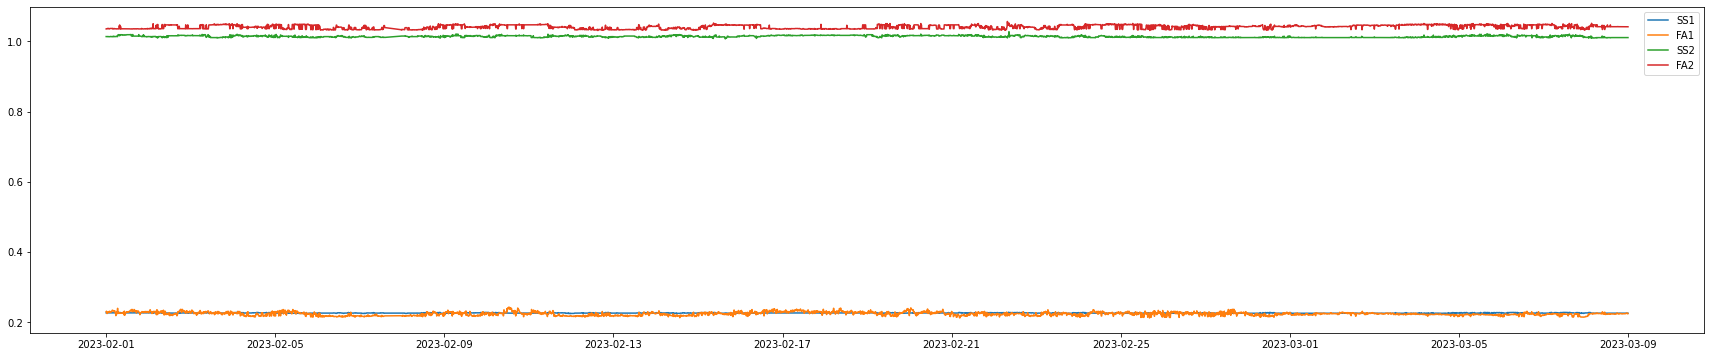

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
predictions = pd.DataFrame(index = inputs.dropna().index)

plt.figure(figsize=(30,6))

for mode in models.keys():
    predictions[mode] = models[mode].predict(inputs.dropna())
    plt.plot(predictions.index, predictions[mode], label = mode)

plt.legend()
plt.show()